In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from importlib import reload
from time import time
import pickle
from copy import deepcopy
import re


import numpy as np
import scipy as sc
import pandas as pd
import torch
print(torch.cuda.is_available())

import models
import utils
import dre
import rna
import vae
import designers
import editdistance

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib_venn import venn2, venn2_circles
plt.rcParams["font.size"] = 14

import seaborn as sns
sns.set_style('whitegrid')

True


2025-01-27 21:45:27.581806: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-27 21:45:27.581833: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-27 21:45:27.582927: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-27 21:45:27.589635: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-27 21:45:29.293116: W tensorflow/comp

# check sampling and labeling progress

In [33]:
# sampled in rna-sample-092324.ipynb and labeled
# last checked 10.18 6p
design_pkl_fname = '/data/wongfanc/rna-results/designs-n5k-110724-5.pkl'
with open(design_pkl_fname, 'rb') as f:
    name2designdata = pickle.load(f)

for name, thing in name2designdata.items():
    print(name, '{:.4f}'.format(np.mean(thing[1])) if thing[1] is not None else None)

cbas-ridge-0.1 0.2958
cbas-ridge-0.2 0.2995
cbas-ridge-0.3 0.3022
cbas-ridge-0.4 0.3057
cbas-ridge-0.5 0.3109
cbas-ridge-0.6 0.3197
cbas-ridge-0.7 0.3357
cbas-ridge-0.8 0.3727
cbas-ridge-0.9 0.4394
dbas-ridge-0.1 0.3350
dbas-ridge-0.2 0.4154
adalead-ridge-0.5 0.3445
adalead-ridge-0.45 0.3447
adalead-ridge-0.4 0.3479
adalead-ridge-0.35 0.3488
adalead-ridge-0.3 0.3531
adalead-ridge-0.25 0.3586
adalead-ridge-0.2 0.3660
adalead-ridge-0.15 0.3767
adalead-ridge-0.1 0.3836
adalead-ridge-0.05 0.4053
adalead-ridge-0.01 0.4080
pex-ridge 0.3461
biswas-ridge-0.02 0.3247
biswas-ridge-0.015 0.3352
biswas-ridge-0.01 0.3514
biswas-ridge-0.005 0.3753
cbas-ff-0.1 0.2900
cbas-ff-0.2 0.2884
cbas-ff-0.3 0.2896
cbas-ff-0.4 0.2912
cbas-ff-0.5 0.2920
cbas-ff-0.6 0.2931
cbas-ff-0.7 0.2918
cbas-ff-0.8 0.2929
cbas-ff-0.9 0.2943
dbas-ff-0.1 0.3146
dbas-ff-0.2 0.3005
dbas-ff-0.3 0.3043
dbas-ff-0.4 0.3338
dbas-ff-0.5 0.3100
dbas-ff-0.6 0.3555
dbas-ff-0.7 0.3261
dbas-ff-0.8 0.3552
dbas-ff-0.9 0.3940
adalead-ff-0.5 0

# plot

In [2]:
# load design names to test (copy from rna-selection-092424.ipynb)

# ----- build menu of design algorithm names -----
adalead_thresholds = [0.2, 0.15, 0.1, 0.05, 0.01]
biswas_temperatures = [0.02, 0.015, 0.01, 0.005]
cbas_dbas_quantiles = np.arange(0.1, 0.91, 0.1)
dbas_ridge_quantiles = [0.1, 0.2]

pp_design_names = ['vae-ridge']
for q in cbas_dbas_quantiles:
    q = round(q, 2)
    pp_design_names.append(f'cbas-ridge-{q}t19')
    
for q in dbas_ridge_quantiles:
    q = round(q, 2)
    pp_design_names.append(f'dbas-ridge-{q}t19')
    
for model_name in ['ridge', 'ff', 'cnn']:
    
    # adalead
    for thresh in adalead_thresholds:
        thresh = round(thresh, 4)
        pp_design_names.append(f'adalead-{model_name}-{thresh}')
    
    # biswas
    for temp in biswas_temperatures:
        temp = round(temp, 4)
        pp_design_names.append(f'biswas-{model_name}-{temp}') 
    
    # PEX
    pp_design_names.append(f'pex-{model_name}') 
        
    if model_name != 'ridge':
        # cbas
        for q in cbas_dbas_quantiles:
            q = round(q, 2)
            pp_design_names.append(f'cbas-{model_name}-{q}')
        
        # dbas
        for q in cbas_dbas_quantiles:
            q = round(q, 2)
            pp_design_names.append(f'dbas-{model_name}-{q}')

In [3]:
# load PP and CP selection results, computed in rna-selection-092424
reload(utils)

target_values = np.arange(0.25, 0.501, 0.003)
n_pp_trial = 200
print_worst = True
pp_results_csv_fname = '/data/wongfanc/rna-results/selection-pp-121624.csv'
cp_results_csv_fname = '/data/wongfanc/rna-results/selection-cp-121624.csv'
pp_truemeans_pkl_fname = '/data/wongfanc/rna-results/selection-pp-121624-truemeans.pkl'

# load CP selection results
cp_df = pd.read_csv(cp_results_csv_fname, index_col=0)
# assert -np.inf LBs in all cases (but if not all trials done, unfilled cells are nan)
print(np.unique(cp_df.to_numpy()))

# load PP selection results and true means
pp_df = pd.read_csv(pp_results_csv_fname, index_col=0)
with open(pp_truemeans_pkl_fname, 'rb') as f:
    pp_name2truemeans = pickle.load(f)

# process for plotting
ppworst_v, pperr_v, ppdisc_v, ppval2configs = utils.process_rna_selection_experiments(
    pp_df, target_values, pp_design_names, pp_name2truemeans, n_pp_trial,
    imp_or_pp='pp', alpha=0.1, print_worst=print_worst
)

[      -inf 0.19890459 0.20012332 ... 0.49735553 0.50068009 0.51772554]
Processing pp results with the following menu of size 78, 84 target values in [0.25, 0.50], 200 trials, and alpha = 0.1:
  vae-ridge
  cbas-ridge-0.1t19
  cbas-ridge-0.2t19
  cbas-ridge-0.3t19
  cbas-ridge-0.4t19
  cbas-ridge-0.5t19
  cbas-ridge-0.6t19
  cbas-ridge-0.7t19
  cbas-ridge-0.8t19
  cbas-ridge-0.9t19
  dbas-ridge-0.1t19
  dbas-ridge-0.2t19
  adalead-ridge-0.2
  adalead-ridge-0.15
  adalead-ridge-0.1
  adalead-ridge-0.05
  adalead-ridge-0.01
  biswas-ridge-0.02
  biswas-ridge-0.015
  biswas-ridge-0.01
  biswas-ridge-0.005
  pex-ridge
  adalead-ff-0.2
  adalead-ff-0.15
  adalead-ff-0.1
  adalead-ff-0.05
  adalead-ff-0.01
  biswas-ff-0.02
  biswas-ff-0.015
  biswas-ff-0.01
  biswas-ff-0.005
  pex-ff
  cbas-ff-0.1
  cbas-ff-0.2
  cbas-ff-0.3
  cbas-ff-0.4
  cbas-ff-0.5
  cbas-ff-0.6
  cbas-ff-0.7
  cbas-ff-0.8
  cbas-ff-0.9
  dbas-ff-0.1
  dbas-ff-0.2
  dbas-ff-0.3
  dbas-ff-0.4
  dbas-ff-0.5
  dbas-ff-0.6
 


Target value 0.3370
  Trial 3 is biswas-ridge-0.015 with true mean label of 0.3362
  Trial 5 is biswas-ridge-0.015 with true mean label of 0.3362
  Trial 6 is biswas-ff-0.015 with true mean label of 0.3341
  Trial 16 is biswas-ridge-0.015 with true mean label of 0.3362
  Trial 27 is biswas-ridge-0.015 with true mean label of 0.3362
  Trial 35 is biswas-ff-0.015 with true mean label of 0.3341
  Trial 36 is biswas-ridge-0.015 with true mean label of 0.3362
  Trial 37 is biswas-ridge-0.02 with true mean label of 0.3261
  Trial 39 is biswas-ridge-0.015 with true mean label of 0.3362
  Trial 55 is biswas-ridge-0.02 with true mean label of 0.3261
  Trial 58 is biswas-ff-0.015 with true mean label of 0.3341
  Trial 64 is biswas-ridge-0.015 with true mean label of 0.3362
  Trial 65 is biswas-ridge-0.02 with true mean label of 0.3261
  Trial 69 is biswas-ridge-0.02 with true mean label of 0.3261
  Trial 78 is biswas-ridge-0.015 with true mean label of 0.3362
  Trial 80 is biswas-ridge-0.015 wi

  Trial 128 is biswas-ff-0.01 with true mean label of 0.3506
  Trial 132 is biswas-ff-0.01 with true mean label of 0.3506
  Trial 136 is biswas-ff-0.01 with true mean label of 0.3506
  Trial 149 is biswas-ff-0.01 with true mean label of 0.3506
  Trial 162 is biswas-ff-0.01 with true mean label of 0.3506
  Trial 172 is biswas-ff-0.01 with true mean label of 0.3506
  Trial 176 is biswas-ff-0.01 with true mean label of 0.3506
  Trial 191 is biswas-ff-0.01 with true mean label of 0.3506
  Trial 196 is biswas-ff-0.01 with true mean label of 0.3506

Target value 0.3550
  Trial 3 is biswas-ridge-0.01 with true mean label of 0.3528
  Trial 6 is biswas-ff-0.01 with true mean label of 0.3506
  Trial 13 is biswas-ridge-0.01 with true mean label of 0.3528
  Trial 16 is biswas-ff-0.01 with true mean label of 0.3506
  Trial 21 is biswas-ridge-0.01 with true mean label of 0.3528
  Trial 27 is biswas-ridge-0.01 with true mean label of 0.3528
  Trial 30 is biswas-ridge-0.01 with true mean label of 0.35

  Trial 44 is adalead-ridge-0.2 with true mean label of 0.3665
  Trial 46 is adalead-ridge-0.2 with true mean label of 0.3665
  Trial 52 is biswas-ridge-0.01 with true mean label of 0.3528
  Trial 54 is adalead-ridge-0.2 with true mean label of 0.3665
  Trial 60 is adalead-ridge-0.2 with true mean label of 0.3665
  Trial 61 is adalead-ridge-0.2 with true mean label of 0.3665
  Trial 64 is biswas-ridge-0.01 with true mean label of 0.3528
  Trial 65 is adalead-ridge-0.2 with true mean label of 0.3665
  Trial 67 is adalead-ridge-0.2 with true mean label of 0.3665
  Trial 71 is adalead-ridge-0.2 with true mean label of 0.3665
  Trial 75 is adalead-ridge-0.2 with true mean label of 0.3665
  Trial 78 is biswas-ridge-0.01 with true mean label of 0.3528
  Trial 79 is adalead-ridge-0.2 with true mean label of 0.3665
  Trial 80 is adalead-ridge-0.2 with true mean label of 0.3665
  Trial 89 is adalead-ridge-0.2 with true mean label of 0.3665
  Trial 93 is adalead-ridge-0.2 with true mean label of

  Trial 41 is adalead-ff-0.2 with true mean label of 0.3698
  Trial 44 is adalead-ridge-0.2 with true mean label of 0.3665
  Trial 46 is adalead-ridge-0.2 with true mean label of 0.3665
  Trial 52 is biswas-ridge-0.005 with true mean label of 0.3718
  Trial 54 is adalead-ridge-0.2 with true mean label of 0.3665
  Trial 55 is adalead-ff-0.2 with true mean label of 0.3698
  Trial 61 is adalead-ridge-0.2 with true mean label of 0.3665
  Trial 64 is adalead-ridge-0.2 with true mean label of 0.3665
  Trial 67 is adalead-ridge-0.2 with true mean label of 0.3665
  Trial 72 is adalead-ff-0.2 with true mean label of 0.3698
  Trial 75 is adalead-ridge-0.2 with true mean label of 0.3665
  Trial 78 is biswas-ridge-0.005 with true mean label of 0.3718
  Trial 79 is adalead-ridge-0.2 with true mean label of 0.3665
  Trial 80 is adalead-ridge-0.2 with true mean label of 0.3665
  Trial 84 is biswas-ridge-0.005 with true mean label of 0.3718
  Trial 89 is adalead-ridge-0.2 with true mean label of 0.366

  Trial 61 is adalead-ridge-0.2 with true mean label of 0.3665
  Trial 64 is adalead-ridge-0.2 with true mean label of 0.3665
  Trial 67 is adalead-ridge-0.2 with true mean label of 0.3665
  Trial 75 is adalead-ridge-0.2 with true mean label of 0.3665
  Trial 78 is biswas-ridge-0.005 with true mean label of 0.3718
  Trial 79 is adalead-ridge-0.2 with true mean label of 0.3665
  Trial 84 is biswas-ridge-0.005 with true mean label of 0.3718
  Trial 89 is adalead-ridge-0.2 with true mean label of 0.3665
  Trial 93 is adalead-ridge-0.2 with true mean label of 0.3665
  Trial 97 is adalead-ff-0.2 with true mean label of 0.3698
  Trial 98 is adalead-ridge-0.2 with true mean label of 0.3665
  Trial 102 is adalead-ridge-0.15 with true mean label of 0.3757
  Trial 111 is adalead-ridge-0.2 with true mean label of 0.3665
  Trial 112 is adalead-ff-0.2 with true mean label of 0.3698
  Trial 115 is adalead-ridge-0.2 with true mean label of 0.3665
  Trial 116 is adalead-ridge-0.2 with true mean label 

  Trial 111 is adalead-ridge-0.2 with true mean label of 0.3665
  Trial 115 is adalead-ridge-0.1 with true mean label of 0.3841
  Trial 116 is adalead-ridge-0.2 with true mean label of 0.3665
  Trial 119 is adalead-ridge-0.1 with true mean label of 0.3841
  Trial 125 is adalead-ridge-0.15 with true mean label of 0.3757
  Trial 133 is adalead-ridge-0.1 with true mean label of 0.3841
  Trial 134 is biswas-ridge-0.005 with true mean label of 0.3718
  Trial 135 is adalead-ridge-0.2 with true mean label of 0.3665
  Trial 137 is adalead-ridge-0.15 with true mean label of 0.3757
  Trial 138 is biswas-ridge-0.005 with true mean label of 0.3718
  Trial 139 is adalead-ridge-0.15 with true mean label of 0.3757
  Trial 140 is biswas-ridge-0.005 with true mean label of 0.3718
  Trial 141 is adalead-ridge-0.15 with true mean label of 0.3757
  Trial 142 is adalead-ridge-0.15 with true mean label of 0.3757
  Trial 143 is adalead-ridge-0.15 with true mean label of 0.3757
  Trial 144 is adalead-ff-0.15 

  Trial 101 is adalead-ff-0.1 with true mean label of 0.3858
  Trial 102 is adalead-ridge-0.1 with true mean label of 0.3841
  Trial 103 is adalead-ff-0.1 with true mean label of 0.3858
  Trial 111 is adalead-ridge-0.2 with true mean label of 0.3665
  Trial 114 is adalead-ff-0.1 with true mean label of 0.3858
  Trial 115 is adalead-ridge-0.1 with true mean label of 0.3841
  Trial 116 is adalead-ridge-0.15 with true mean label of 0.3757
  Trial 119 is adalead-ridge-0.1 with true mean label of 0.3841
  Trial 125 is adalead-ridge-0.15 with true mean label of 0.3757
  Trial 135 is adalead-ridge-0.2 with true mean label of 0.3665
  Trial 137 is adalead-ridge-0.15 with true mean label of 0.3757
  Trial 139 is adalead-ridge-0.15 with true mean label of 0.3757
  Trial 141 is adalead-ridge-0.1 with true mean label of 0.3841
  Trial 142 is adalead-ridge-0.15 with true mean label of 0.3757
  Trial 143 is adalead-ridge-0.15 with true mean label of 0.3757
  Trial 144 is adalead-ridge-0.1 with true 

  Trial 57 is adalead-ridge-0.1 with true mean label of 0.3841
  Trial 61 is adalead-ridge-0.1 with true mean label of 0.3841
  Trial 64 is adalead-ridge-0.1 with true mean label of 0.3841
  Trial 79 is adalead-ridge-0.15 with true mean label of 0.3757
  Trial 80 is adalead-ridge-0.1 with true mean label of 0.3841
  Trial 86 is adalead-ridge-0.1 with true mean label of 0.3841
  Trial 89 is adalead-ridge-0.15 with true mean label of 0.3757
  Trial 93 is adalead-ridge-0.1 with true mean label of 0.3841
  Trial 98 is adalead-ridge-0.15 with true mean label of 0.3757
  Trial 108 is dbas-ridge-0.2t19 with true mean label of 0.3928
  Trial 109 is dbas-ridge-0.2t19 with true mean label of 0.3928
  Trial 110 is dbas-ridge-0.2t19 with true mean label of 0.3928
  Trial 111 is adalead-ridge-0.15 with true mean label of 0.3757
  Trial 115 is adalead-ridge-0.1 with true mean label of 0.3841
  Trial 116 is adalead-ridge-0.15 with true mean label of 0.3757
  Trial 119 is adalead-ridge-0.1 with true m

  Trial 36 is adalead-ridge-0.01 with true mean label of 0.4079
  Trial 41 is adalead-ff-0.05 with true mean label of 0.4077
  Trial 43 is adalead-ridge-0.05 with true mean label of 0.4049
  Trial 44 is adalead-ridge-0.1 with true mean label of 0.3841
  Trial 47 is adalead-ridge-0.05 with true mean label of 0.4049
  Trial 53 is adalead-ridge-0.05 with true mean label of 0.4049
  Trial 54 is adalead-ff-0.05 with true mean label of 0.4077
  Trial 57 is adalead-ridge-0.05 with true mean label of 0.4049
  Trial 61 is adalead-ridge-0.05 with true mean label of 0.4049
  Trial 62 is adalead-ridge-0.01 with true mean label of 0.4079
  Trial 65 is adalead-ridge-0.05 with true mean label of 0.4049
  Trial 67 is adalead-ridge-0.05 with true mean label of 0.4049
  Trial 71 is adalead-ridge-0.05 with true mean label of 0.4049
  Trial 72 is adalead-ridge-0.05 with true mean label of 0.4049
  Trial 74 is adalead-ridge-0.05 with true mean label of 0.4049
  Trial 78 is adalead-ridge-0.05 with true mean

  Trial 41 is adalead-ff-0.05 with true mean label of 0.4077
  Trial 47 is adalead-ridge-0.05 with true mean label of 0.4049
  Trial 53 is adalead-ridge-0.05 with true mean label of 0.4049
  Trial 61 is adalead-ridge-0.05 with true mean label of 0.4049
  Trial 62 is adalead-ridge-0.01 with true mean label of 0.4079
  Trial 65 is adalead-ridge-0.05 with true mean label of 0.4049
  Trial 67 is adalead-ridge-0.05 with true mean label of 0.4049
  Trial 71 is adalead-ridge-0.05 with true mean label of 0.4049
  Trial 72 is adalead-ridge-0.05 with true mean label of 0.4049
  Trial 74 is adalead-ridge-0.05 with true mean label of 0.4049
  Trial 80 is adalead-ridge-0.01 with true mean label of 0.4079
  Trial 82 is adalead-ridge-0.05 with true mean label of 0.4049
  Trial 86 is adalead-ridge-0.05 with true mean label of 0.4049
  Trial 98 is adalead-ridge-0.05 with true mean label of 0.4049
  Trial 107 is adalead-ridge-0.05 with true mean label of 0.4049
  Trial 111 is adalead-ridge-0.1 with true

  Trial 109 is cbas-ridge-0.9t19 with true mean label of 0.4261
  Trial 118 is cbas-ridge-0.9t19 with true mean label of 0.4261
  Trial 121 is cbas-ridge-0.9t19 with true mean label of 0.4261
  Trial 122 is cbas-ridge-0.9t19 with true mean label of 0.4261
  Trial 123 is adalead-ridge-0.05 with true mean label of 0.4049
  Trial 124 is cbas-ridge-0.9t19 with true mean label of 0.4261
  Trial 127 is adalead-ridge-0.05 with true mean label of 0.4049
  Trial 134 is cbas-ridge-0.9t19 with true mean label of 0.4261
  Trial 137 is cbas-ridge-0.9t19 with true mean label of 0.4261
  Trial 138 is cbas-ridge-0.9t19 with true mean label of 0.4261
  Trial 142 is cbas-ridge-0.9t19 with true mean label of 0.4261
  Trial 148 is adalead-ridge-0.05 with true mean label of 0.4049
  Trial 149 is adalead-ridge-0.05 with true mean label of 0.4049
  Trial 151 is cbas-ridge-0.9t19 with true mean label of 0.4261
  Trial 152 is cbas-ridge-0.9t19 with true mean label of 0.4261
  Trial 161 is cbas-ridge-0.9t19 wit

  Trial 13 is cbas-ridge-0.9t19 with true mean label of 0.4261
  Trial 16 is cbas-ridge-0.9t19 with true mean label of 0.4261
  Trial 30 is cbas-ridge-0.9t19 with true mean label of 0.4261
  Trial 54 is cbas-ridge-0.9t19 with true mean label of 0.4261
  Trial 71 is cbas-ridge-0.9t19 with true mean label of 0.4261
  Trial 82 is cbas-ridge-0.9t19 with true mean label of 0.4261
  Trial 86 is cbas-ridge-0.9t19 with true mean label of 0.4261
  Trial 98 is cbas-ridge-0.9t19 with true mean label of 0.4261
  Trial 104 is cbas-ridge-0.9t19 with true mean label of 0.4261
  Trial 123 is cbas-ridge-0.9t19 with true mean label of 0.4261
  Trial 124 is cbas-ridge-0.9t19 with true mean label of 0.4261
  Trial 134 is cbas-ridge-0.9t19 with true mean label of 0.4261
  Trial 137 is cbas-ridge-0.9t19 with true mean label of 0.4261
  Trial 151 is cbas-ridge-0.9t19 with true mean label of 0.4261
  Trial 166 is cbas-ridge-0.9t19 with true mean label of 0.4261
  Trial 168 is cbas-ridge-0.9t19 with true mean 

In [4]:
# marginally calibrated forecasts
reload(utils)
mcworst_v, mcerr_v, mcdisc_v = utils.process_rna_qc_selection_experiments(
    cp_df,
    target_values,
    pp_design_names,
    pp_name2truemeans,
    n_pp_trial
)

In [5]:
# load imputation design names to test

# ----- build menu of design algorithm names -----
adalead_thresholds = [0.2, 0.15, 0.1, 0.05, 0.01]
biswas_temperatures = [0.02, 0.015, 0.01, 0.005]
cbas_dbas_quantiles = np.arange(0.1, 0.91, 0.1)
dbas_ridge_quantiles = [0.1, 0.2]

imp_design_names = ['vae-ridge']
    
for q in dbas_ridge_quantiles:
    q = round(q, 2)
    imp_design_names.append(f'dbas-ridge-{q}')
    
for model_name in ['ridge', 'ff', 'cnn']:
    
    # adalead
    for thresh in adalead_thresholds:
        thresh = round(thresh, 4)
        imp_design_names.append(f'adalead-{model_name}-{thresh}')
    
    # biswas
    for temp in biswas_temperatures:
        temp = round(temp, 4)
        imp_design_names.append(f'biswas-{model_name}-{temp}') 
    
    # PEX
    imp_design_names.append(f'pex-{model_name}') 
    
    # CbAS
    for q in cbas_dbas_quantiles:
        q = round(q, 2)
        imp_design_names.append(f'cbas-{model_name}-{q}')
        
    # dbas
    if model_name != 'ridge':
        for q in cbas_dbas_quantiles:
            q = round(q, 2)
            imp_design_names.append(f'dbas-{model_name}-{q}')

In [6]:
# load imputation selection results, computed in rna-selection-092424.ipynb
reload(utils)

n_imp_trial = 10
imp_results_csv_fname = '/data/wongfanc/rna-results/selection-imputation-102124.csv'
imp_truemeans_pkl_fname = '/data/wongfanc/rna-results/selection-imputation-102124-truemeans.pkl'

imp_df = pd.read_csv(imp_results_csv_fname, index_col=0)
with open(imp_truemeans_pkl_fname, 'rb') as f:
    imp_name2truemeans = pickle.load(f)
    
impworst_v, imperr_v, impdisc_v, impval2configs = utils.process_rna_selection_experiments(
    imp_df, target_values, imp_design_names, imp_name2truemeans, n_imp_trial, imp_or_pp='imp', alpha=0.1
)

Processing imp results with the following menu of size 78, 84 target values in [0.25, 0.50], 10 trials, and alpha = 0.1:
  vae-ridge
  dbas-ridge-0.1
  dbas-ridge-0.2
  adalead-ridge-0.2
  adalead-ridge-0.15
  adalead-ridge-0.1
  adalead-ridge-0.05
  adalead-ridge-0.01
  biswas-ridge-0.02
  biswas-ridge-0.015
  biswas-ridge-0.01
  biswas-ridge-0.005
  pex-ridge
  cbas-ridge-0.1
  cbas-ridge-0.2
  cbas-ridge-0.3
  cbas-ridge-0.4
  cbas-ridge-0.5
  cbas-ridge-0.6
  cbas-ridge-0.7
  cbas-ridge-0.8
  cbas-ridge-0.9
  adalead-ff-0.2
  adalead-ff-0.15
  adalead-ff-0.1
  adalead-ff-0.05
  adalead-ff-0.01
  biswas-ff-0.02
  biswas-ff-0.015
  biswas-ff-0.01
  biswas-ff-0.005
  pex-ff
  cbas-ff-0.1
  cbas-ff-0.2
  cbas-ff-0.3
  cbas-ff-0.4
  cbas-ff-0.5
  cbas-ff-0.6
  cbas-ff-0.7
  cbas-ff-0.8
  cbas-ff-0.9
  dbas-ff-0.1
  dbas-ff-0.2
  dbas-ff-0.3
  dbas-ff-0.4
  dbas-ff-0.5
  dbas-ff-0.6
  dbas-ff-0.7
  dbas-ff-0.8
  dbas-ff-0.9
  adalead-cnn-0.2
  adalead-cnn-0.15
  adalead-cnn-0.1
  adalead

In [7]:
# load wheelock results, computed in rna-wheelock-111224.ipynb
reload(utils)
gmm_csv_fname = '/data/wongfanc/rna-results/selection-wheelock-ped-111424.csv'
qs = [0, 0.5, 1]

gmm_df = pd.read_csv(gmm_csv_fname, index_col=0)
gmm_type2results = utils.process_wheelock_selection_experiments(
    gmm_df, target_values, imp_design_names, imp_name2truemeans, n_imp_trial, qs=qs
)

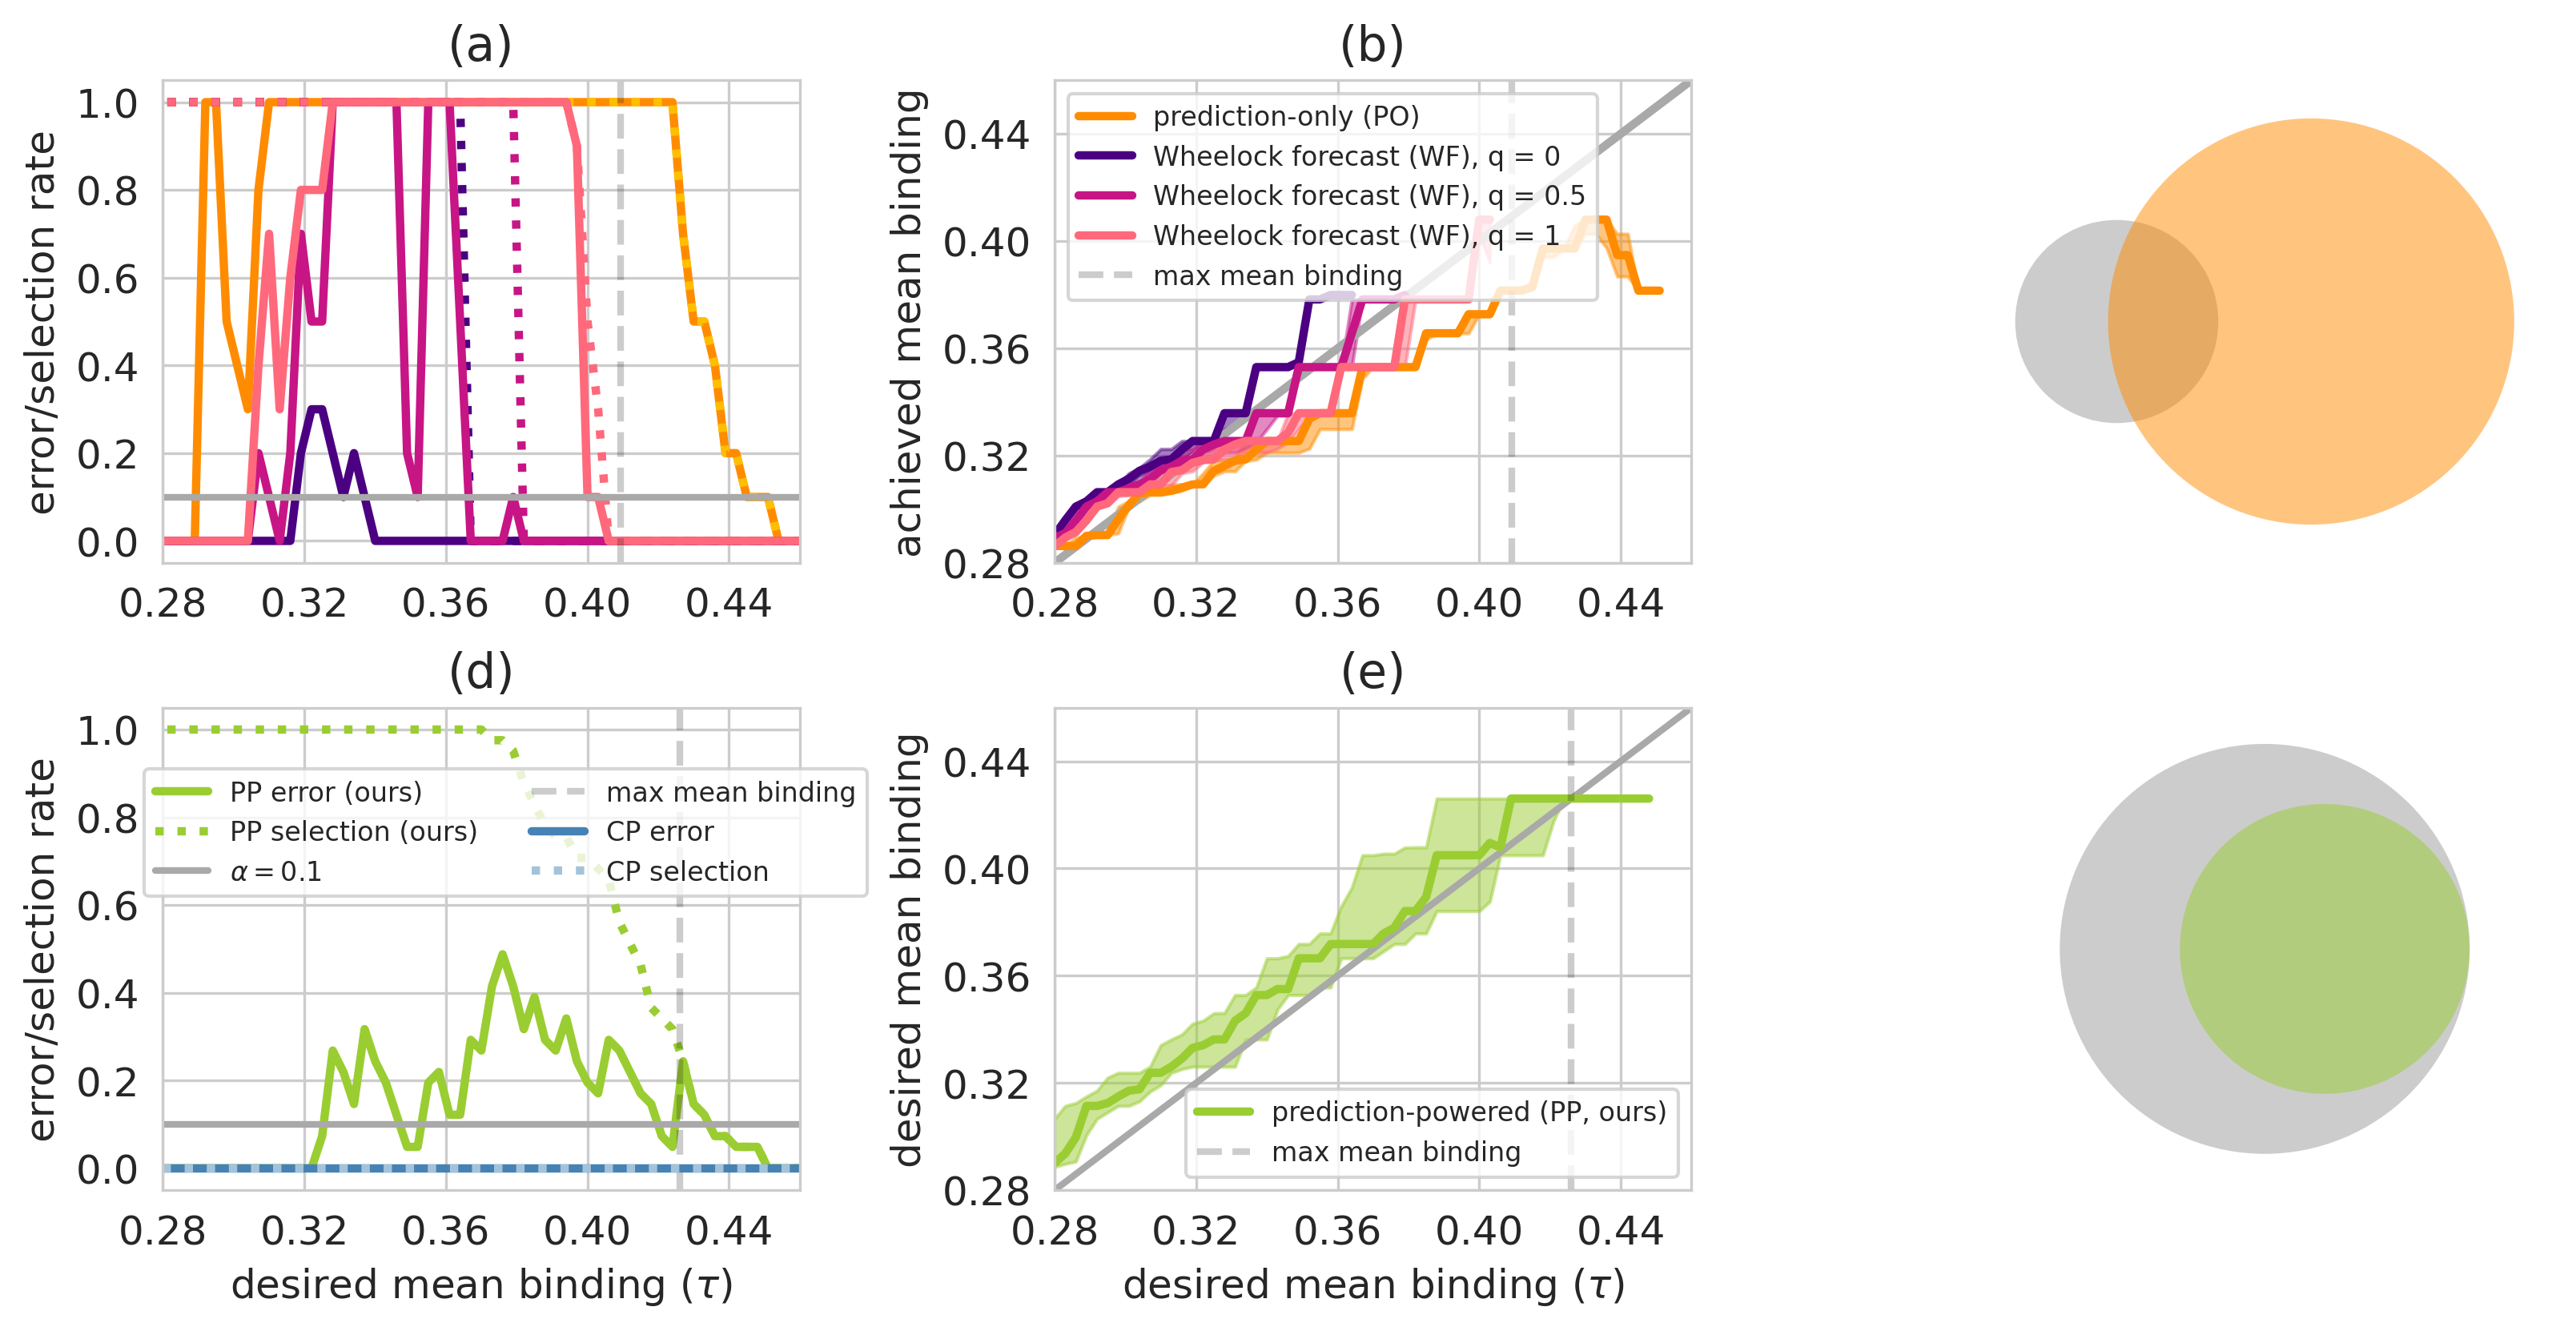

In [40]:
# plot two-row figure
fig, axs = plt.subplots(2, 3, figsize=(13, 6), dpi=300)
ax00 = axs[0, 0]
ax10 = axs[1, 0]
ax01 = axs[0, 1]
ax11 = axs[1, 1]
ax02 = axs[0, 2]
ax12 = axs[1, 2]
fig.subplots_adjust(wspace=0.4, hspace=0.3)

alpha = 0.1
imp_color = 'darkorange'
pp_color = 'yellowgreen'
wf_colors = ['indigo', 'mediumvioletred', '#ff697b']
dark_line_color = 'k'
lw = 2.5

imp_max_achievable = np.max([np.mean(means_t) for means_t in imp_name2truemeans.values()])
pp_max_achievable = np.max(list(pp_name2truemeans.values()))
imp_xlim = [0.28, 0.46]
imp_xticks = np.arange(0.28, 0.47, 0.04)
pp_xlim = [0.28, 0.46]
pp_xticks = np.arange(0.28, 0.47, 0.04)

# ===== subplots (a, d) =====

ax00.plot(target_values, imperr_v, c=imp_color, linewidth=lw, label='PO error');
ax00.plot(target_values, impdisc_v, ':', c=(255/255, 191/255, 0), linewidth=lw, label='PO selection');
for q_idx, q in enumerate(qs):
    # qa = 0.3 + (1 - q) * 0.7
    _, wferr_v, wfdisc_v, _ = wf_type2results['cs'][q]
    ax00.plot(target_values, wferr_v, c=wf_colors[q_idx], linewidth=lw, label='forecast error');
    ax00.plot(target_values, wfdisc_v, ':', c=wf_colors[q_idx], linewidth=lw, label='forecast selection');
#     _, wferr_v, wfdisc_v = wf_type2results['no-cs'][q]
#     ax00.plot(imp_target_values, wferr_v, c=wf_nocs_color, alpha=qa, linewidth=lw);
#     ax00.plot(imp_target_values, wfdisc_v, ':', c=wf_nocs_color, alpha=qa, linewidth=lw);

ax00.axhline(alpha, linestyle='--', color=dark_line_color, alpha=1, linewidth=2, label=r'$\alpha = {}$'.format(alpha));
ax00.axvline(imp_max_achievable, linestyle='--', color='k', linewidth=2, alpha=0.2, label='max mean binding')
# ax00.legend(fontsize=8)
ax00.set_ylabel('error/selection rate');
ax00.set_ylim([-0.05, 1.05])
ax00.set_yticks(np.arange(0, 1.05, 0.2))
ax00.set_xlim(imp_xlim)
ax00.set_xticks(imp_xticks)
ax00.set_title('(a)')


ax10.plot(target_values, pperr_v, c=pp_color, linewidth=lw, label='PP error (ours)');
ax10.plot(target_values, ppdisc_v, ':', c=pp_color, linewidth=lw, label='PP selection (ours)');
ax10.axhline(alpha, linestyle='-', color=dark_line_color, alpha=1, linewidth=2, label=r'$\alpha = {}$'.format(alpha));
ax10.axvline(pp_max_achievable, linestyle='--', color='k', linewidth=2, alpha=0.2, label='max mean binding')
ax10.axhline(0, color='steelblue', linewidth=lw, label='CP error');
ax10.axhline(0, color=(164/255, 195/255, 218/255), linestyle=':', linewidth=lw, label='CP selection');
ax10.legend(fontsize=8, ncol=2, loc='upper left', bbox_to_anchor=(-0.05, 0.9))
ax10.set_ylabel('error/selection rate');
ax10.set_xlabel(r'desired mean binding ($\tau$)');
ax10.set_ylim([-0.05, 1.05])
ax10.set_yticks(np.arange(0, 1.05, 0.2))
ax10.set_xticks(pp_xticks)
ax10.set_xlim(pp_xlim)
ax10.set_title('(d)')


# ===== subplots (b, e) =====

q_low = 0.2
q_high = 0.8

ax01.plot(
    [np.min(target_values) - 0.02, np.max(target_values) + 0.02],
    [np.min(target_values) - 0.02, np.max(target_values) + 0.02],
    c=dark_line_color, alpha=1, linewidth=lw
);
ax01.plot(
    target_values, [np.median(worst) if len(worst) else np.nan for worst in impworst_v],
    c=imp_color, label='prediction-only (PO)', linewidth=lw,
)
ax01.fill_between(
    target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in impworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in impworst_v],
    color=imp_color, alpha=0.5,
)
for q_idx, q in enumerate(qs):
    # qa = 0.3 + (1 - q) * 0.7
    wfworst_v, _, _, _ = wf_type2results['cs'][q]
    ax01.plot(
        target_values, [np.median(worst) if len(worst) else np.nan for worst in wfworst_v],
        c=wf_colors[q_idx], label=f'Wheelock forecast (WF), q = {q}', linewidth=lw,
    )
    ax01.fill_between(
        target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in wfworst_v],
        [np.quantile(worst, q_high) if len(worst) else np.nan for worst in wfworst_v],
        color=wf_colors[q_idx], alpha=0.5,
    )
#     wfworst_v, _, _ = wf_type2results['no-cs'][q]
#     ax01.plot(
#         imp_target_values, [np.median(worst) if len(worst) else np.nan for worst in wfworst_v],
#         c=wf_nocs_color, alpha=qa, label='Wheelock forecast (WF)', linewidth=lw,
#     )
#     ax01.fill_between(
#         imp_target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in wfworst_v],
#         [np.quantile(worst, q_high) if len(worst) else np.nan for worst in wfworst_v],
#         color=wf_nocs_color, alpha=0.5 * qa,
#     )
ax01.axvline(imp_max_achievable, linestyle='--', linewidth=2, color='k', alpha=0.2, label='max mean binding')
ax01.legend(fontsize=8)
ax01.set_ylabel('achieved mean binding');
ax01.set_xlim(imp_xlim)
ax01.set_ylim(imp_xlim)
ax01.set_xticks(imp_xticks)
ax01.set_yticks(imp_xticks)
ax01.set_title('(b)')

ax11.plot([np.min(target_values) - 0.02, np.max(target_values) + 0.02],
          [np.min(target_values) - 0.02, np.max(target_values) + 0.02],
          c=dark_line_color, alpha=1, linewidth=2)
ax11.plot(
    target_values, [np.median(worst) if len(worst) else np.nan for worst in ppworst_v],
    c=pp_color, label='prediction-powered (PP, ours)', linewidth=lw,
)
ax11.fill_between(
    target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in ppworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in ppworst_v],
    color=pp_color, alpha=0.5,
)
ax11.axvline(pp_max_achievable, linestyle='--', linewidth=2, color='k', alpha=0.2, label='max mean binding')
ax11.legend(fontsize=8)
ax11.set_xlabel(r'desired mean binding ($\tau$)');
ax11.set_ylabel('desired mean binding');
ax11.set_xlim(pp_xlim)
ax11.set_ylim(pp_xlim)
ax11.set_xticks(pp_xticks)
ax11.set_yticks(pp_xticks)
ax11.set_title('(e)')


# ===== subplots (c, f) =====

v = venn2_circles(subsets = (1, 7, 1), ax=ax02);
v[0].set_color('black')
v[0].set_alpha(0.2)
v[0].set_lw(0)
v[1].set_color(imp_color)
v[1].set_alpha(0.5)
v[1].set_lw(0)

v = venn2_circles(subsets = (1, 0, 1), ax=ax12);
v[0].set_color('black')
v[0].set_alpha(0.2)
v[0].set_lw(0)
v[1].set_color(pp_color)
v[1].set_alpha(0.5)
v[1].set_lw(0)

# plt.savefig('../figures/gb1-.png')


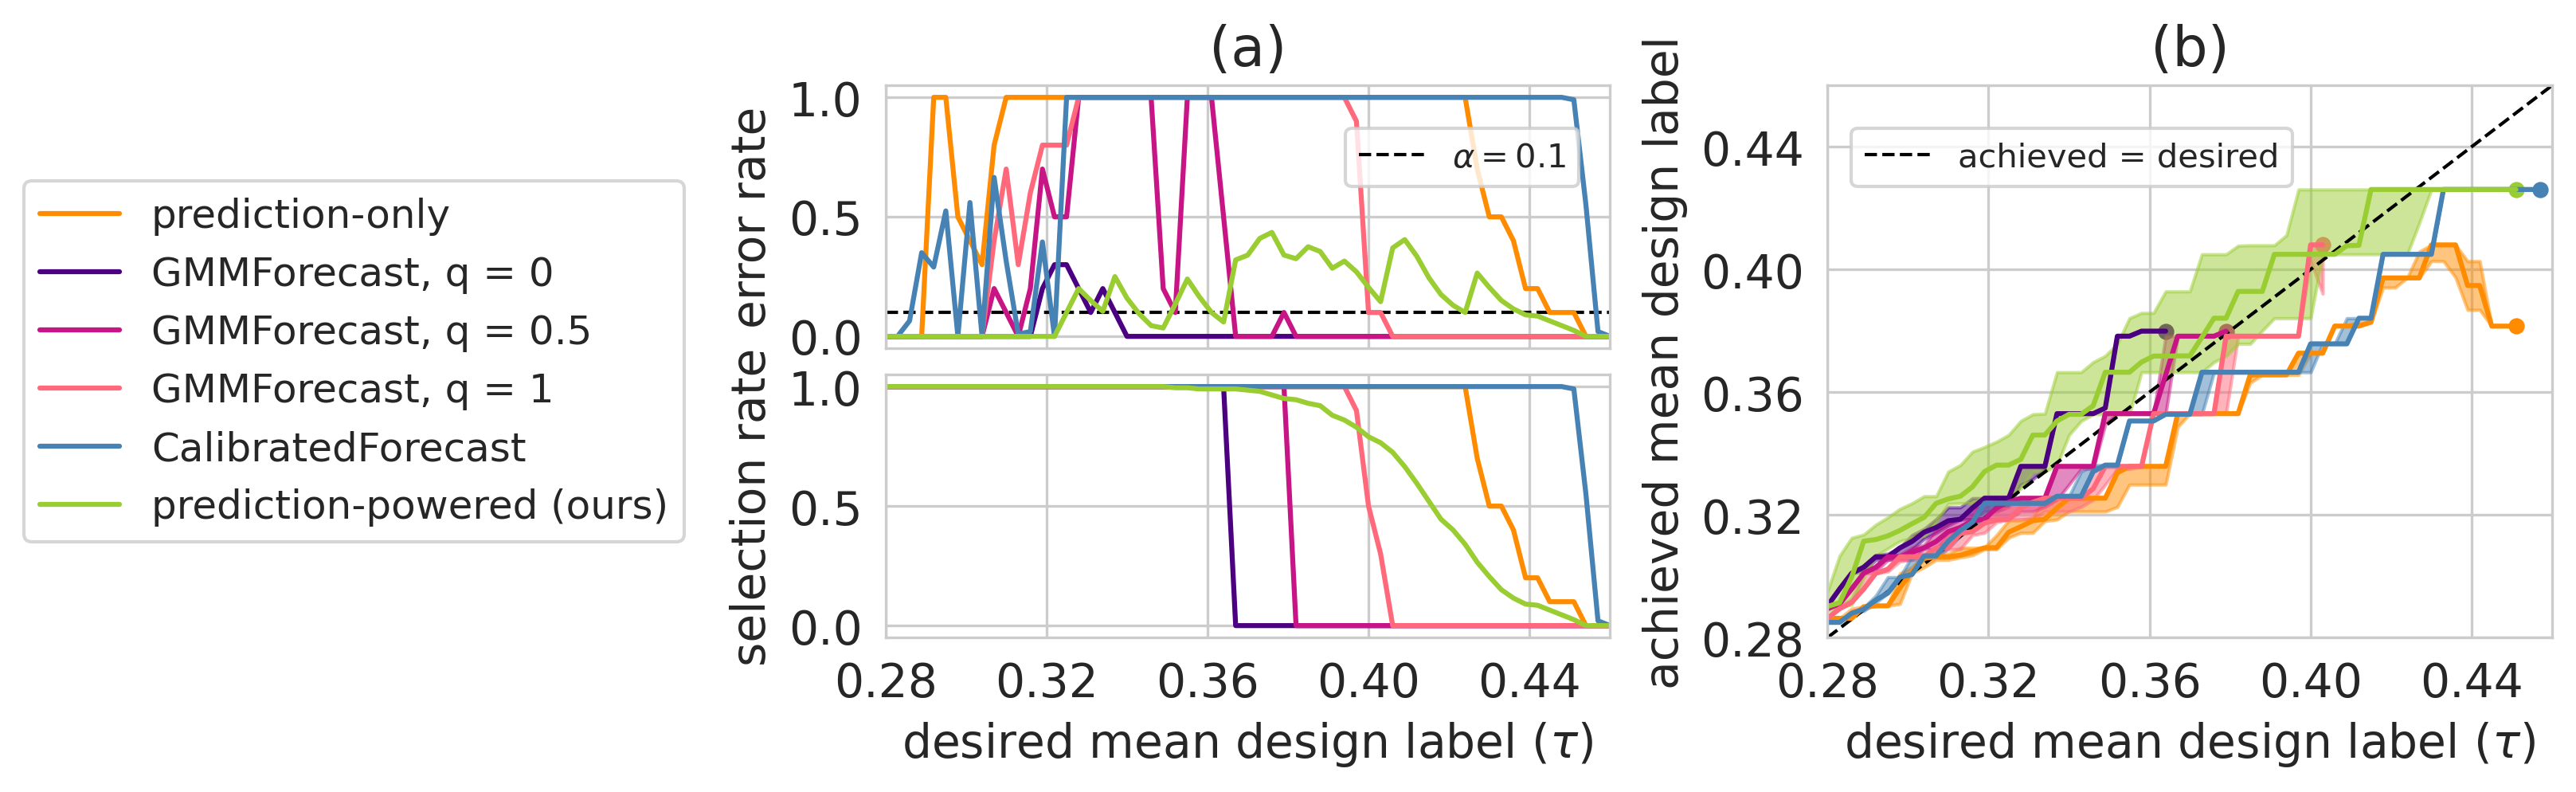

In [13]:
# one-row figure
sns.set_style('whitegrid')
fig = plt.figure(figsize=(9, 3), dpi=300)

gs = gridspec.GridSpec(1, 2, figure=fig)
gs0 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0])

ax1 = fig.add_subplot(gs[1])
ax00 = fig.add_subplot(gs0[0])
ax10 = fig.add_subplot(gs0[1])

fig.subplots_adjust(wspace=0.3)
fig.subplots_adjust(hspace=0.1)

alpha = 0.1
gmm_type = 'cs'
imp_color = 'darkorange'
pp_color = 'yellowgreen'
gmm_colors = ['indigo', 'mediumvioletred', '#ff697b']
dark_line_color = 'k'

lw = 1.5
dark_lw = 1
legend_fs = 12
err_lim = [-0.05, 1.05]
err_ticks = [0, 0.5, 1]
tau_lim = [0.28, 0.46]
tau_ticks = np.arange(0.28, 0.46, 0.04)
marker_sz = 15


q_low = 0.2
q_high = 0.8


# ===== subplot (a) =====

# ----- top (error) -----
ax00.axhline(alpha, linestyle='--', color=dark_line_color, alpha=1, linewidth=dark_lw, label=r'$\alpha = {}$'.format(alpha));

ax00.plot(target_values, imperr_v, c=imp_color, linewidth=lw);
for q_idx, q in enumerate(qs):
    _, gmmerr_v, gmmdisc_v, _ = gmm_type2results[gmm_type][q]
    ax00.plot(target_values, gmmerr_v, c=gmm_colors[q_idx], linewidth=lw);
ax00.plot(target_values, mcerr_v, c='steelblue', linewidth=lw);
ax00.plot(target_values, pperr_v, c=pp_color, linewidth=lw);

ax00.set_yticks(err_ticks)
ax00.set_xlim(tau_lim)
ax00.set_ylim(err_lim)
ax00.set_xticks(tau_ticks)
ax00.set_xticklabels([])
ax00.set_ylabel('error rate');
ax00.set_title('(a)');

# dummy so get legend labels
ax00.legend(fontsize=10, loc='upper right', bbox_to_anchor=(0.98, 0.9));


# ----- bottom (selection rate) -----

ax10.plot(target_values, impdisc_v, '-', c=imp_color, linewidth=lw);
for q_idx, q in enumerate(qs):
    _, gmmerr_v, gmmdisc_v, _ = gmm_type2results[gmm_type][q]
    ax10.plot(target_values, gmmdisc_v, '-', c=gmm_colors[q_idx], linewidth=lw);
ax10.plot(target_values, mcdisc_v, '-', c='steelblue', linewidth=lw);
ax10.plot(target_values, ppdisc_v, '-', c=pp_color, linewidth=lw);

# dummy so get legend for (b)
ax10.plot([-1, -1], [-1, -1], '--', c=dark_line_color, linewidth=dark_lw, label='achieved = desired')
ax10.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1.31, 2));

ax10.set_xlim(tau_lim)
ax10.set_ylim(err_lim)
ax10.set_xticks(tau_ticks)
ax10.set_yticks(err_ticks)
ax10.set_ylabel('selection rate');
ax10.set_xlabel(r'desired mean design label ($\tau$)');



# ===== subplot (b) =====

ax1.plot(tau_lim, tau_lim, '--', c=dark_line_color, alpha=1, linewidth=dark_lw);
median_v = [np.median(worst) if len(worst) else np.nan for worst in impworst_v]
ax1.plot(
    target_values, median_v,
    c=imp_color, label='prediction-only', linewidth=lw,
)

last_idx = np.where(np.isnan(median_v))[0][0] - 1
ax1.scatter(target_values[last_idx], median_v[last_idx], c=imp_color, s=marker_sz, alpha=1)
    
ax1.fill_between(
    target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in impworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in impworst_v],
    color=imp_color, alpha=0.5,
)

for q_idx, q in enumerate(qs):
    gmmworst_v, _, _, _ = gmm_type2results[gmm_type][q]
    median_v = [np.median(worst) if len(worst) else np.nan for worst in gmmworst_v]
    ax1.plot(
        target_values, median_v,
        c=gmm_colors[q_idx], label=f'GMMForecast, q = {q}', linewidth=lw,
    )
    
    last_idx = np.where(np.isnan(median_v))[0][0] - 1
    ax1.scatter(target_values[last_idx], median_v[last_idx], c=gmm_colors[q_idx], s=marker_sz, alpha=1)
    
    ax1.fill_between(
        target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in gmmworst_v],
        [np.quantile(worst, q_high) if len(worst) else np.nan for worst in gmmworst_v],
        color=gmm_colors[q_idx], alpha=0.5,
    )

median_v = [np.median(worst) if len(worst) else np.nan for worst in mcworst_v]  
ax1.plot(
    target_values, median_v,
    c='steelblue', label='CalibratedForecast', linewidth=lw,
)
last_idx = np.where(np.isnan(median_v))[0][0] - 1
ax1.scatter(target_values[last_idx], median_v[last_idx], c='steelblue', s=marker_sz, alpha=1)
ax1.fill_between(
    target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in mcworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in mcworst_v],
    color='steelblue', alpha=0.5,
)

median_v = [np.median(worst) if len(worst) else np.nan for worst in ppworst_v]  
ax1.plot(
    target_values, [np.median(worst) if len(worst) else np.nan for worst in ppworst_v],
    c=pp_color, label='prediction-powered (ours)', linewidth=lw,
)
last_idx = np.where(np.isnan(median_v))[0][0] - 1
ax1.scatter(target_values[last_idx], median_v[last_idx], c=pp_color, s=marker_sz, alpha=1)
ax1.fill_between(
    target_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in ppworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in ppworst_v],
    color=pp_color, alpha=0.5,
)

ax1.set_xlim(tau_lim)
ax1.set_ylim(tau_lim)
ax1.set_xticks(tau_ticks)
ax1.set_yticks(tau_ticks)
# ax1.legend(fontsize=legend_f;s, loc='center left', bbox_to_anchor=(1.05, 0.5))
ax1.legend(fontsize=legend_fs, loc='center right', bbox_to_anchor=(-1.55, 0.5))

ax1.set_title('(b)')
ax1.set_ylabel('achieved mean design label');
ax1.set_xlabel(r'desired mean design label ($\tau$)');


# find examples for venn diagrams

In [127]:
# construct mapping from target value to 10k configurations that achieve it
imp_val2trueconfigs = {round(val, 4): [] for val in imp_target_values}
for name, means_t in imp_name2truemeans.items():
    for val in imp_target_values:
        val = round(val, 4)
        if np.mean(means_t) >= val:
            if name not in imp_val2trueconfigs[val]:
                imp_val2trueconfigs[val].append(name)
            

In [167]:
# find trials where not all successful configurations are selected,
# for imputation venn diagram
for val in imp_target_values:
    val = round(val, 4)
    if val > 0.4:
        trueconfigs = set(imp_val2trueconfigs[val])
        for name in trueconfigs:
            for t in range(2):
                selectedconfigs = set(impval2configs[val][t])
                if name not in selectedconfigs:
                    print(val,
                          len(trueconfigs.difference(selectedconfigs)),
                          len(selectedconfigs.difference(trueconfigs)),
                          len(trueconfigs.intersection(selectedconfigs)))
                    print(trueconfigs.difference(selectedconfigs))
                    print(selectedconfigs.difference(trueconfigs))
                    print(trueconfigs.intersection(selectedconfigs))

0.406 1 6 0
{'adalead-cnn-0.01'}
{'cbas-ridge-0.9t19', 'adalead-ridge-0.1', 'adalead-ff-0.05', 'adalead-ridge-0.05', 'adalead-ridge-0.01', 'adalead-ff-0.01'}
set()
0.406 1 6 0
{'adalead-cnn-0.01'}
{'cbas-ridge-0.9t19', 'adalead-ridge-0.1', 'adalead-ff-0.05', 'adalead-ridge-0.05', 'adalead-ridge-0.01', 'adalead-ff-0.01'}
set()


In [148]:
# find trials where not all successful configurations are selected,
# for Wheelock venn diagram
for v, val in enumerate(imp_target_values):
    val = round(val, 4)
    if val >= 0.4:
        
        trueconfigs = set(imp_val2trueconfigs[val])
        
        for t in range(n_imp_trial):
            
            selectedconfigs = set(wf_type2results['cs'][1.][3][val][t])
            
            if len(selectedconfigs):
                print(val, t)
                print(trueconfigs)
                print(selectedconfigs)

0.4 2
{'adalead-cnn-0.01', 'cbas-ridge-0.9', 'adalead-ff-0.01'}
{'cbas-ridge-0.9'}
0.4 3
{'adalead-cnn-0.01', 'cbas-ridge-0.9', 'adalead-ff-0.01'}
{'cbas-ridge-0.9'}
0.4 6
{'adalead-cnn-0.01', 'cbas-ridge-0.9', 'adalead-ff-0.01'}
{'cbas-ridge-0.9'}
0.4 7
{'adalead-cnn-0.01', 'cbas-ridge-0.9', 'adalead-ff-0.01'}
{'dbas-ridge-0.2'}
0.4 8
{'adalead-cnn-0.01', 'cbas-ridge-0.9', 'adalead-ff-0.01'}
{'cbas-ridge-0.9'}
0.403 2
{'adalead-cnn-0.01', 'cbas-ridge-0.9'}
{'cbas-ridge-0.9'}
0.403 3
{'adalead-cnn-0.01', 'cbas-ridge-0.9'}
{'cbas-ridge-0.9'}
0.403 7
{'adalead-cnn-0.01', 'cbas-ridge-0.9'}
{'dbas-ridge-0.2'}


In [147]:
# construct mapping from target value to PP configurations that achieve it
pp_val2trueconfigs = {round(val, 4): [] for val in pp_target_values}
for name, mean in pp_name2truemeans.items():
    for val in pp_target_values:
        val = round(val, 4)
        if mean >= val:
            assert(name not in pp_val2trueconfigs[val])
            pp_val2trueconfigs[val].append(name)
            

In [165]:
# find trials where not all achieving configurations are selected,
# for PP venn diagram
trial_idx = 13
for val in pp_target_values:
    val = round(val, 4)
    if val > 0.4:
        trueconfigs = set(val2trueconfigs[val])
        selectedconfigs = set(ppval2configs[val][trial_idx])
        
        for name in trueconfigs:
            if name not in selectedconfigs:  # look for when didn't select some successful ones
                print(val,
                      len(trueconfigs.difference(selectedconfigs)),
                      len(selectedconfigs.difference(trueconfigs)),
                      len(trueconfigs.intersection(selectedconfigs)))
                print(trueconfigs.difference(selectedconfigs))
                print(selectedconfigs.difference(trueconfigs))
                print(trueconfigs.intersection(selectedconfigs))

0.402 1 0 1
{'adalead-cnn-0.01'}
set()
{'cbas-ridge-0.9t19'}
0.406 1 1 0
{'adalead-cnn-0.01'}
{'cbas-ridge-0.9t19'}
set()
